In [1]:
import numpy as np
import matplotlib.pyplot as plt
from libra_toolbox.neutron_detection.diamond.process_data import DataProcessor
from datetime import datetime
import json

In [2]:
path_to_data_folder = "../../../data/neutron_detection"

In [3]:
def add_files_from_npy(filename, data_proc):
    data = np.load(filename)
    data_proc.time_values = np.append(data_proc.time_values, data[0])
    data_proc.energy_values = np.append(data_proc.energy_values, data[1])

In [4]:
# day 1 data part 1
start_day_1_part_1 = datetime.strptime("2024/12/10: 10:53am", "%Y/%m/%d: %I:%M%p")
data_day_1_part_1 = DataProcessor()
data_day_1_part_1.start_time = 0.0
add_files_from_npy(
    f"{path_to_data_folder}/binary_data_day_1_part_1.npy",
    data_day_1_part_1,
)

In [5]:
# day 1 data part 2
start_day_1_part_2 = datetime.strptime("2024/12/10: 7:52pm", "%Y/%m/%d: %I:%M%p")

# convert start time to seconds after start of part 1
start_day_1_part_2 = (start_day_1_part_2 - start_day_1_part_1).total_seconds()
data_proc_day_1_part2 = DataProcessor()
data_proc_day_1_part2.start_time = start_day_1_part_2
add_files_from_npy(
    f"{path_to_data_folder}/binary_data_day_1_part_2.npy",
    data_proc_day_1_part2,
)
data_proc_day_1_part2.time_values += start_day_1_part_2

In [6]:
# day 2 data
start_day_2 = datetime.strptime("2024/12/11: 10:19am", "%Y/%m/%d: %I:%M%p")
start_day_2 = (start_day_2 - start_day_1_part_1).total_seconds()
data_proc_day_2 = DataProcessor()
data_proc_day_2.start_time = start_day_2
add_files_from_npy(
    f"{path_to_data_folder}/binary_data_day_2.npy",
    data_proc_day_2,
)
data_proc_day_2.time_values += start_day_2

In [7]:
# -------- read irradiations from logbook ----------------

with open("../../../data/general.json", "r") as f:
    general_data = json.load(f)

# read start time from general.json
all_start_times = []
for generator in general_data["generators"]:
    if generator["enabled"] is False:
        continue
    for irradiation_period in generator["periods"]:
        start_time = datetime.strptime(irradiation_period["start"], "%m/%d/%Y %H:%M")
        all_start_times.append(start_time)
start_time = min(all_start_times)


irradiations = []
for generator in general_data["generators"]:
    if generator["enabled"] is False:
        continue
    for irradiation_period in generator["periods"]:
        irr_start_time = (
            datetime.strptime(irradiation_period["start"], "%m/%d/%Y %H:%M")
            - start_time
        )
        irr_stop_time = (
            datetime.strptime(irradiation_period["end"], "%m/%d/%Y %H:%M") - start_time
        )


        irr_start_time = irr_start_time.total_seconds()
        irr_stop_time = irr_stop_time.total_seconds()

        irradiations.append([irr_start_time, irr_stop_time])

In [8]:
for i, data_proc in enumerate(
    [data_day_1_part_1, data_proc_day_1_part2, data_proc_day_2]
):

    # 30-35 minutes lag due to the time it takes to save one file in COMPASS.
    if i == 2:
        # for day 2, lag is longer because more counts were recorded in each file
        lag = 40 * 60
    else:
        lag = 30 * 60
    data_proc.time_values = data_proc.time_values - lag
    data_proc.start_time = data_proc.start_time - lag

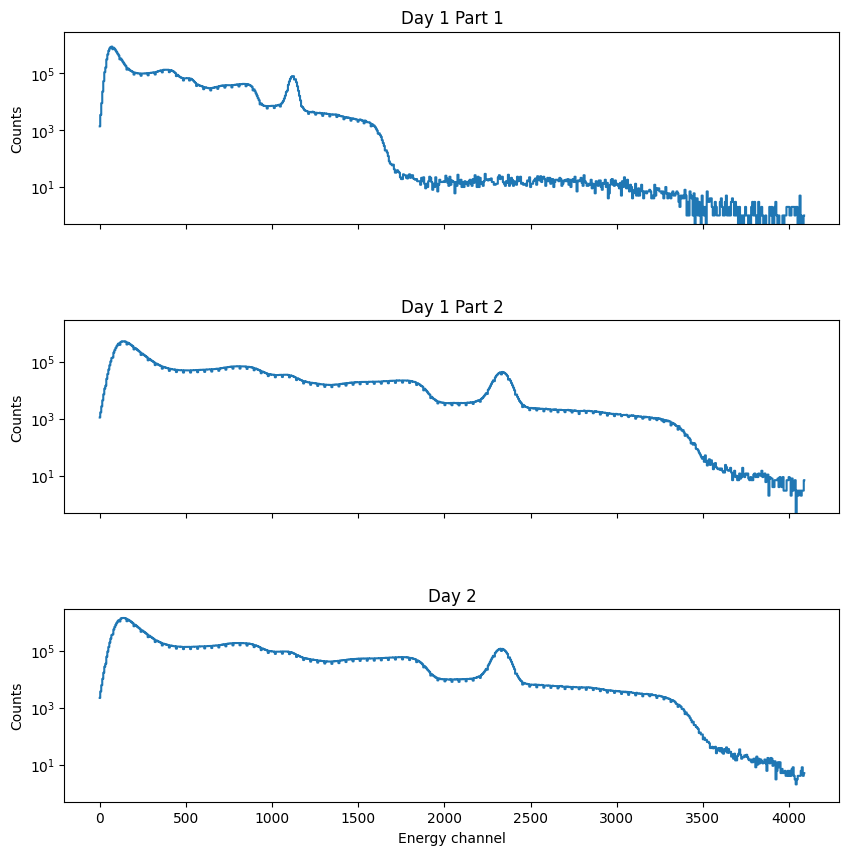

In [9]:
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(10, 10))

nb_bins = 700

data_parts = [
    (data_day_1_part_1, "Day 1 Part 1", axs[0]),
    (data_proc_day_1_part2, "Day 1 Part 2", axs[1]),
    (data_proc_day_2, "Day 2", axs[2]),
]

for data, title, ax in data_parts:
    bins = np.linspace(data.energy_values.min(), data.energy_values.max(), num=nb_bins)
    counts, energy_bins = np.histogram(data.energy_values, bins=bins)
    ax.step(energy_bins[:-1], counts, where="mid", label=title)
    ax.set_title(title)
    ax.set_ylabel("Counts")

axs[2].set_xlabel("Energy channel")

plt.yscale("log")

# add more horizontal space between subplots
plt.subplots_adjust(hspace=0.5)

plt.show()

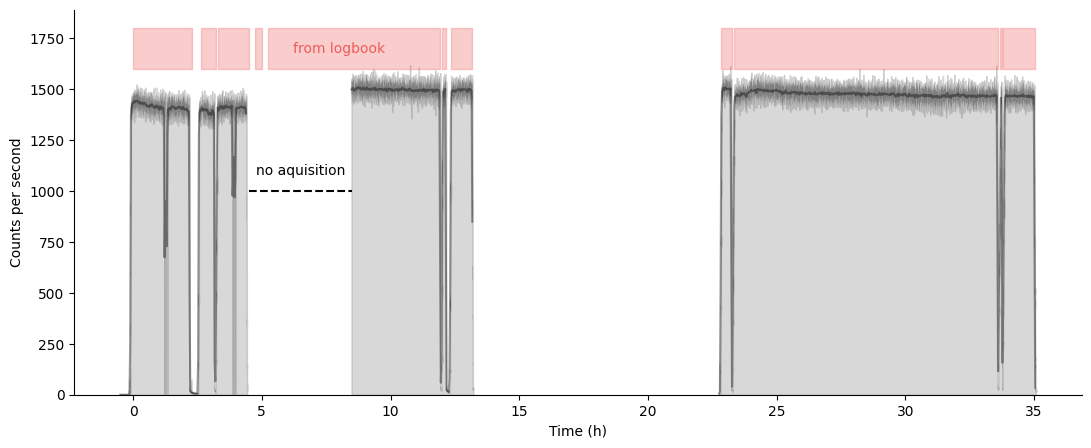

In [30]:
s_to_h = 1 / 3600

plt.figure(figsize=(13, 5))

for i, data_proc in enumerate(
    [data_day_1_part_1, data_proc_day_1_part2, data_proc_day_2]
):

    rates, bins = data_proc.get_count_rate(bin_time=2)

    plt.plot(bins[:-1] * s_to_h, rates, color="tab:grey", linewidth=0.051)
    plt.fill_between(bins[:-1] * s_to_h, rates, alpha=0.3, color="tab:grey")

    rates, bins = data_proc.get_count_rate(bin_time=100)
    plt.plot(bins[:-1] * s_to_h, rates, color="black", alpha=0.4)


# plot irradiations from logbook
for i, irr in enumerate(irradiations):
    plt.fill_betweenx(
        [1600, 1800],
        irr[0] * s_to_h,
        irr[1] * s_to_h,
        color="#EF5B5B",
        alpha=0.3,
    )
plt.annotate(
    "from logbook",
    (7, 1600),
    xytext=(8, 1700),
    ha="center",
    va="center",
    color="#EF5B5B",
)

# line for no aquisition period
plt.hlines(y=1000, xmin=4.5, xmax=8.5, linestyles="dashed", color="black")
plt.annotate("no aquisition", (6.5, 1000), xytext=(6.5, 1100), ha="center", va="center")

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.ylabel("Counts per second")
plt.xlabel("Time (h)")
plt.ylim(bottom=0)

plt.savefig("out.png")
plt.show()
